In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM, GRU, Embedding
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.4.1


In [2]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete58PYXL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete58PYXL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete58PYXL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data: tf.raw_ops.PrefetchDataset = imdb["train"]
test_data: tf.raw_ops.PrefetchDataset = imdb["test"]

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s, l in tqdm(train_data):
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s, l in tqdm(test_data):
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

100%|██████████| 25000/25000 [00:05<00:00, 4668.89it/s]


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(
    num_words=vocab_size, 
    oov_token=oov_tok
)
tokenizer.fit_on_texts(training_sentences)
word_index: dict = tokenizer.word_index

sequences: [[int]] = tokenizer.texts_to_sequences(training_sentences)
padded: np.ndarray = pad_sequences(
    sequences,
    maxlen=max_length, 
    truncating=trunc_type
)

testing_sequences: [[int]] = tokenizer.texts_to_sequences(testing_sentences)
testing_padded: np.ndarray = pad_sequences(
    testing_sequences,
    maxlen=max_length
)

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [6]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_1", input_length=max_length),
    Bidirectional(GRU(units=32, return_sequences=False), name="GRU_2"),
    Dense(units=6, activation='relu', name="dense_3"),
    Dense(units=1, activation='sigmoid', name="dense_4")
], name="imdb_classifier_GRU")
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "imdb_classifier_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
GRU_2 (Bidirectional)        (None, 64)                9600      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 50
history: History = model.fit(
    x=padded, 
    y=training_labels_final, 
    validation_data=(testing_padded, testing_labels_final),
    epochs=num_epochs, 
    verbose=1,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/50
782/782 [==============================] - 7s 8ms/step - loss: 0.5945 - accuracy: 0.6852 - val_loss: 0.4339 - val_accuracy: 0.8431
Epoch 2/50
782/782 [==============================] - 5s 7ms/step - loss: 0.3642 - accuracy: 0.8841 - val_loss: 0.4017 - val_accuracy: 0.8377
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2792 - accuracy: 0.9118 - val_loss: 0.4324 - val_accuracy: 0.8336
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2228 - accuracy: 0.9333 - val_loss: 0.4342 - val_accuracy: 0.8262
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1862 - accuracy: 0.9489 - val_loss: 0.5022 - val_accuracy: 0.8260
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1598 - accuracy: 0.9568 - val_loss: 0.6071 - val_accuracy: 0.8243
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1361 - accuracy: 0.9643 - val_loss: 0.6586 - val_accuracy: 0.8212
Epoch 

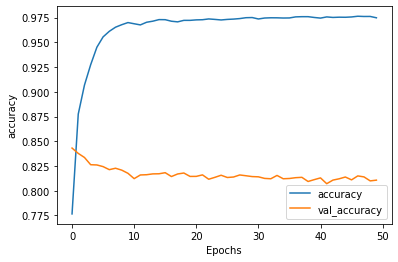

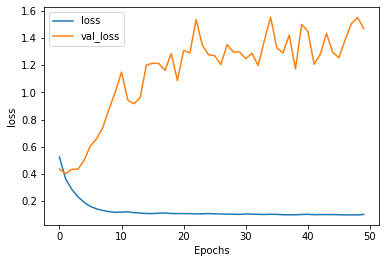

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [9]:
# Model Definition with LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_1", input_length=max_length),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_2"),
    Dense(units=6, activation='relu', name="dense_3"),
    Dense(units=1, activation='sigmoid', name="dense_4")
], name="imdb_classifier_LSTM")
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "imdb_classifier_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 64)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Model Definition with Conv1D
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_1", input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu', name="conv1d_2"),
    GlobalAveragePooling1D(name="avg_2"),
    Dense(units=6, activation='relu', name="dense_3"),
    Dense(units=1, activation='sigmoid', name="dense_4")
], name="imdb_classifier_conv1d")
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "imdb_classifier_conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
avg_2 (GlobalAveragePooling1 (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________
